# Introducción

En este análisis, nuestro objetivo principal es explorar las relaciones causales que podrían influir en la probabilidad de aprobar la primera evaluación del curso, utilizando la biblioteca DoWhy en Python. Previamente, se llevó a cabo un análisis de importancia de características utilizando SHAP, identificando varias características que parecen tener un impacto significativo. Ahora, con DoWhy, intentamos ir más allá del mero diagnóstico de importancia y explorar cómo estas características interactúan y posiblemente causan los cambios observados en la probabilidad de aprobación.

## Análisis de Características Principales con SHAP

Inicialmente, realizamos un análisis con SHAP para identificar las características más relevantes que afectan la probabilidad de aprobación. Según este análisis, las características más influyentes son:

- `hito1`
- `e29`
- `exitosos`
- `fallidos`
- `e42`
- `e3`
- `e35`
- `e13`
- `e26`
- `e18`
- `e32`
- `e10`
- `e0`
- `e4`
- `e23`
- `e7`
- `e17`
- `e25`
- `e22`
- `e8`

Estas características fueron identificadas como las más críticas, excluyendo `hito2` y otras columnas no listadas.

## Integración con Análisis de Causalidad DoWhy

Para profundizar nuestro entendimiento, integramos los insights obtenidos a través de SHAP con un análisis de causalidad utilizando DoWhy. Este análisis nos permite investigar cómo las características identificadas como importantes por SHAP influyen causalmente en la aprobación. A través de este análisis, buscamos responder preguntas cruciales como:

1. ¿Cómo la variación en `Todas las variables` afecta directa e indirectamente la aprobación?
2. ¿Cómo los efectos causales identificados pueden influir en la estrategia de intervención para mejorar las tasas de aprobación?

Para esto se realizara una `hiteracion` entre `Todas las variables` y `aprobado`


In [1]:
import os
import warnings
from sys import path

import matplotlib.pyplot as plt
import numpy as np

import dowhy
import dowhy.causal_estimators.linear_regression_estimator
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from dowhy import CausalModel
from sklearn.ensemble import RandomForestRegressor

for dirname, _, filenames in os.walk("../../../resources/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath("../../../"))

from custom import functions

warnings.filterwarnings("ignore")

# Read and preview data
df = pd.read_csv(
    "../../../resources/v2_hitosExitoFalloColESol1.csv",
    delimiter=";",
    skipinitialspace=True,
)

# creando columna aprobado y con la funcion set_in_aprobado_nota poblamos la nueva columna.
df["aprobado"] = df.apply(lambda x: functions.set_in_aprobado_nota(x["sol1"]), axis=1)
# revisamos la existencia de la nueva columna.
print(df.columns)

../../../resources/allColProSol.xlsx
../../../resources/dataset_a_2021.csv
../../../resources/dataset_a_2021c2.csv
../../../resources/dataset_a_2021v1.xlsx
../../../resources/dataset_unab_ORIGINAL SIN P1.csv
../../../resources/dataset_unab_P1.csv
../../../resources/exitoFallidoEnviosProgramaSol.xlsx
../../../resources/exitoFallidoProgramaSol.xlsx
../../../resources/exitosoFallidosEnviosAllColProSol.xlsx
../../../resources/exitosoFallidosEnviosAllColSol.xlsx
../../../resources/exitososFallidosEnviosSol.xlsx
../../../resources/Hito12sinColCeroExitosoFallidosSol.xlsx
../../../resources/sinColCeroExitosoFallidosEnviosSol.xlsx
../../../resources/sinColCeroExitosoFallidosSol.xlsx
../../../resources/v2_hitosExitoFalloColESol1.csv
../../../resources/v2_hitosExitoFalloColESol1Prograna.csv
../../../resources/v2_hitosExitoFalloSol1Programa.csv
../../../resources/causalidad\causalidad.dot
../../../resources/causalidad\causalidad.png
../../../resources/causalidad\causalidad_e29.dot
../../../resourc

In [2]:
# Array preguntasGuia treatment
preguntasGuia = [
    "hito1",
    "fallidos",
    "exitosos",
    "e42",
    "e35",
    "e32",
    "e29",
    "e26",
    "e25",
    "e23",
    "e22",
    "e18",
    "e17",
    "e13",
    "e10",
    "e8",
    "e7",
    "e4",
    "e3",
    "e0",
]
# vairable outcome
outcome_variable = "aprobado"
# Lista para almacenar los resultados
results = []

In [3]:
# la funcion run_causal_model ejecuta el modelo segun los parametos de treatment y outcome
def run_causal_model(treatment_variable, outcome_variable):
    # Paso 1: Modelar un problema causal
    model = CausalModel(
        data=df,
        treatment=treatment_variable,
        outcome=outcome_variable,
        graph="""
            digraph {        
                e42 -> exitosos;
                e42 -> fallidos;
                e42 -> hito1;
                e29 -> exitosos;
                e29 -> fallidos;
                e29 -> hito1;
                e3 -> exitosos;
                e3 -> fallidos;
                e3 -> hito1;
                e35 -> exitosos;
                e35 -> fallidos;
                e35 -> hito1;
                e13 -> exitosos;
                e13 -> fallidos;
                e13 -> hito1;
                e26 -> exitosos;
                e26 -> fallidos;
                e26 -> hito1;
                e18 -> exitosos;
                e18 -> fallidos;
                e18 -> hito1;
                e32 -> exitosos;
                e32 -> fallidos;
                e32 -> hito1;
                e10 -> exitosos;
                e10 -> fallidos;
                e10 -> hito1;
                e0 -> exitosos;
                e0 -> fallidos;
                e0 -> hito1;
                e4 -> exitosos;
                e4 -> fallidos;
                e4 -> hito1;
                e23 -> exitosos;
                e23 -> fallidos;
                e23 -> hito1;
                e7 -> exitosos;
                e7 -> fallidos;
                e7 -> hito1;
                e17 -> exitosos;
                e17 -> fallidos;
                e17 -> hito1;
                e25 -> exitosos;
                e25 -> fallidos;
                e25 -> hito1;
                e22 -> exitosos;
                e22 -> fallidos;
                e22 -> hito1;
                e8 -> exitosos;
                e8 -> fallidos;
                e8 -> hito1;

                hito1 -> aprobado;
                exitosos -> aprobado;

                fallidos -> exitosos;
                
                exitosos -> hito1;
            }
            """,
    )

    # Paso 2: Identificar el estimando objetivo bajo el modelo
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    # print(identified_estimand)

    # Paso 3: Estimar el efecto causal usando un método basado en árboles
    estimate = model.estimate_effect(
        identified_estimand,
        test_significance=True,  # para realizar una estimacion significativa en los test
        method_name="backdoor.econml.dml.DML",
        control_value=0,
        treatment_value=1,
        target_units="ate",  # Average Treatment Effect
        method_params={
            "init_params": {
                "model_y": RandomForestRegressor(),
                "model_t": RandomForestRegressor(),
                "model_final": RandomForestRegressor(
                    max_depth=10,
                    min_samples_split=10,
                    min_samples_leaf=5,
                    random_state=1502,
                    n_estimators=500,
                ),
                "featurizer": None,
            },
            "fit_params": {},
        },
    )

    # print("----------------------------")
    # print("Estimado de efecto causal:")
    # print(estimate.value)
    # print("----------------------------")

    # Refutador de datos aleatorios
    refute1 = model.refute_estimate(
        identified_estimand, estimate, method_name="random_common_cause"
    )
    # print(refute1)

    # Refutador de causa común no observada
    refute2 = model.refute_estimate(
        identified_estimand,
        estimate,
        method_name="add_unobserved_common_cause",
        confounders_effect_on_treatment="binary_flip",
        confounders_effect_on_outcome="binary_flip",
        effect_strength_on_treatment=0.01,
        effect_strength_on_outcome=0.02,
    )
    # print(refute2)

    # Paso 4: Refutar el estimado obtenido
    refute3 = model.refute_estimate(
        identified_estimand,
        estimate,
        method_name="placebo_treatment_refuter",
        placebo_type="permute",
    )
    # print(refute3)

    # print(causal_estimate_nie)
    print("fin: " + str(treatment_variable))
    # Obtener el valor p del test de significancia
    significance_test_result = estimate.test_stat_significance()
    p_value = significance_test_result["p_value"]

    # Asegúrate de devolver cualquier resultado que desees almacenar
    return {
        "Variable de Tratamiento": treatment_variable,
        "Variable de Resultado": outcome_variable,
        "Estimación del Efecto Causal": estimate.value,
        "Valor p": p_value,
        "Tipo (Causa Común Aleatoria)": refute1.refutation_type,
        "CCA Efecto Estimado": refute1.estimated_effect,
        "CCA - Nuevo Efecto": refute1.new_effect,
        "CCA - Valor p": refute1.refutation_result["p_value"],
        "Tipo (Causa Común No Observada)": refute2.refutation_type,
        "CCNO - Efecto Estimado": refute2.estimated_effect,
        "CCNO - Nuevo Efecto": refute2.new_effect,
        "Tipo (Tratamiento Placebo)": refute3.refutation_type,
        "TP - Efecto Estimado": refute3.estimated_effect,
        "TP - Nuevo Efecto": refute3.new_effect,
        "TP - Valor p": refute3.refutation_result["p_value"],
    }

In [4]:
# Iterar sobre cada variable en preguntasGuia y el outcome aprobado
for pregunta in preguntasGuia:
    result = run_causal_model(pregunta, outcome_variable)
    results.append(result)

fin: hito1
fin: fallidos
fin: exitosos
fin: e42
fin: e35
fin: e32
fin: e29
fin: e26
fin: e25
fin: e23
fin: e22
fin: e18
fin: e17
fin: e13
fin: e10
fin: e8
fin: e7
fin: e4
fin: e3
fin: e0


In [13]:
# Convertir los resultados en un DataFrame para visualizarlos en una tabla
results_df = pd.DataFrame(results)

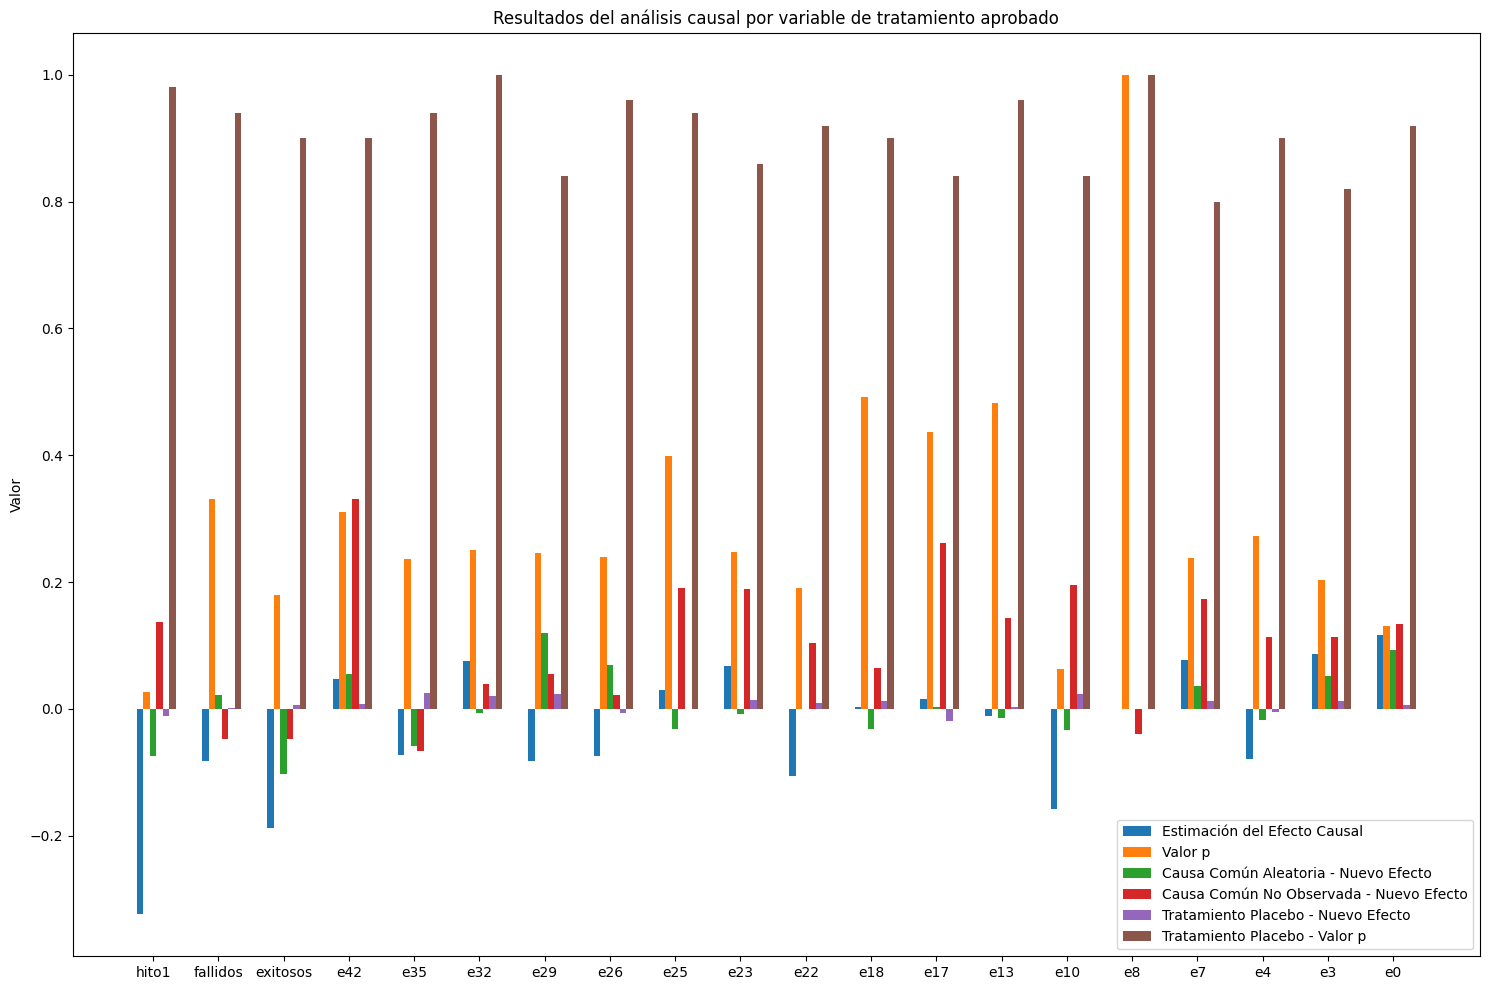

In [16]:
# Si los valores p son rangos, toma el promedio del rango
results_df["Valor p"] = results_df["Valor p"].apply(
    lambda x: (x[0] + x[1]) / 2 if isinstance(x, tuple) else x
)

# Desplegando el grafico
plt.figure(figsize=(15, 10))
x = np.arange(len(results_df["Variable de Tratamiento"]))
width = 0.1
plt.bar(
    x - 2 * width,
    results_df["Estimación del Efecto Causal"],
    width,
    label="Estimación del Efecto Causal",
)
plt.bar(x - 1 * width, results_df["Valor p"], width, label="Valor p")
plt.bar(
    x,
    results_df["CCA - Nuevo Efecto"],
    width,
    label="Causa Común Aleatoria - Nuevo Efecto",
)
plt.bar(
    x + 1 * width,
    results_df["CCNO - Nuevo Efecto"],
    width,
    label="Causa Común No Observada - Nuevo Efecto",
)
plt.bar(
    x + 2 * width,
    results_df["TP - Nuevo Efecto"],
    width,
    label="Tratamiento Placebo - Nuevo Efecto",
)
plt.bar(
    x + 3 * width,
    results_df["TP - Valor p"],
    width,
    label="Tratamiento Placebo - Valor p",
)
plt.ylabel("Valor")
plt.title(
    "Resultados del análisis causal por variable de tratamiento " + outcome_variable
)
plt.xticks(x, results_df["Variable de Tratamiento"])
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Ver los resultados
print("Resultados finales en df")
print(results_df)

Resultados finales en df
   Variable de Tratamiento Variable de Resultado  \
0                    hito1              aprobado   
1                 fallidos              aprobado   
2                 exitosos              aprobado   
3                      e42              aprobado   
4                      e35              aprobado   
5                      e32              aprobado   
6                      e29              aprobado   
7                      e26              aprobado   
8                      e25              aprobado   
9                      e23              aprobado   
10                     e22              aprobado   
11                     e18              aprobado   
12                     e17              aprobado   
13                     e13              aprobado   
14                     e10              aprobado   
15                      e8              aprobado   
16                      e7              aprobado   
17                      e4             

### Conclusión

A través del análisis causal realizado, se investigó cómo diferentes variables asociadas a una guía de apoyo podrían influir en la probabilidad de aprobar la primera evaluación del curso. Las variables de interés incluyeron `hito1`, `exitosos`, `fallidos` y las preguntas de la guia presentadas en la introduccion.

# Resultados Numéricos

Los modelos causales construidos proporcionaron las siguientes estimaciones del efecto causal y valores p para el tratamiento placebo:

1. **Estimación del Efecto Causal**:

   - Los modelos causales sugieren una asociación entre las variables de interés y la probabilidad de aprobar, aunque la magnitud y dirección de estas asociaciones varían.

2. **Resultados Numéricos**:

   - **Modelo hito1**:
     - Estimación del Efecto Causal: -0.323999
     - Valor p: 0.0270
     - Causa Común No Observada - Nuevo Efecto: 0.137109
   - **Modelo exitosos**:
     - Estimación del Efecto Causal: -0.188152
     - Valor p: 0.1800
     - Causa Común No Observada - Nuevo Efecto: -0.047411
   - **Modelo e10**:
     - Estimación del Efecto Causal: -0.157919
     - Valor p: 0.0630
     - Causa Común No Observada - Nuevo Efecto: 0.194838
   - **Modelo e0**:
     - Estimación del Efecto Causal: 0.117109
     - Valor p: 0.1310
     - Causa Común No Observada - Nuevo Efecto: 0.133503
   - **Modelo e3**:
     - Estimación del Efecto Causal: 0.086197
     - Valor p: 0.2030
     - Causa Común No Observada - Nuevo Efecto: 0.112686

3. **Refutaciones**:

   - Las refutaciones indican una posible sensibilidad de la estimación del efecto causal a causas comunes no observadas y aleatorias, lo que sugiere la necesidad de explorar más a fondo las suposiciones del modelo.

4. **Tratamiento Placebo - Interpretación**:

   - El tratamiento placebo en el análisis introduce una variable de tratamiento ficticia para evaluar la robustez de las estimaciones del efecto causal.

5. **Interpretación del Valor p**:

   - Un valor p bajo (≤ 0.05) sugiere que los resultados son estadísticamente significativos y que es menos probable que sean producto del azar.
   - Un valor p alto (> 0.05) sugiere que los resultados no son estadísticamente significativos y que la relación observada podría ser producto del azar.

6. **Relevancia de las Variables**:

   - Las variables `hito1`, `exitosos` y `e10` mostraron las estimaciones del efecto causal más significativas, lo que indica una mayor relevancia de estas variables en el análisis causal.

7. **Implicaciones**:

   - Los resultados proporcionan una visión inicial sobre cómo la guía de apoyo podría influir en la probabilidad de aprobar la primera evaluación del curso. Sin embargo, la interpretación de la relevancia y el impacto de las variables requiere una consideración cuidadosa de las suposiciones del modelo y posiblemente una exploración adicional mediante análisis de sensibilidad o recopilación de datos adicionales.

8. **Consideraciones Adicionales**:
   - También es crucial considerar la calidad y la cantidad de los datos, así como la adecuación de las suposiciones del modelo y la metodología de análisis.

Este análisis representa un paso inicial hacia la comprensión de las relaciones causales entre la participación en una guía de apoyo y el rendimiento académico, y destaca la importancia de considerar las suposiciones del modelo y las variables confundidoras en la interpretación de los resultados.
